In [18]:
import matplotlib.pyplot as plt
import pandas as pd 
import os
import pywt
import numpy as np
import csv
from scipy import stats
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 


In [19]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec
path = os.path.join(os.getcwd(),'mitbih_database')
window_size = 450
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(os.path.join(path, filename + file_extension))

    # *.txt
    else:
        annotations.append(os.path.join(path, filename + file_extension))
print(records)

['d:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\100.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\101.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\102.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\103.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\104.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\105.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\106.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\107.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\108.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\109.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\111.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\112.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\113.csv', 'd:\\Projec

In [20]:
# Records
for r in range(0, len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    signals = denoise(signals)    
    signals = stats.zscore(signals)
    

    example_beat_printed = False
    
    stride = 50
    
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data), stride):  # Step by stride
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)  # Time... Clipping
            pos = int(next(splitted))  # Sample ID
            arrhythmia_type = next(splitted)  # Type
            
            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                
                if window_size <= pos < (len(signals) - window_size):
                    beat = signals[pos - window_size : pos + window_size]

                    # Add to the dataset
                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


(1983, 900) (1983,)


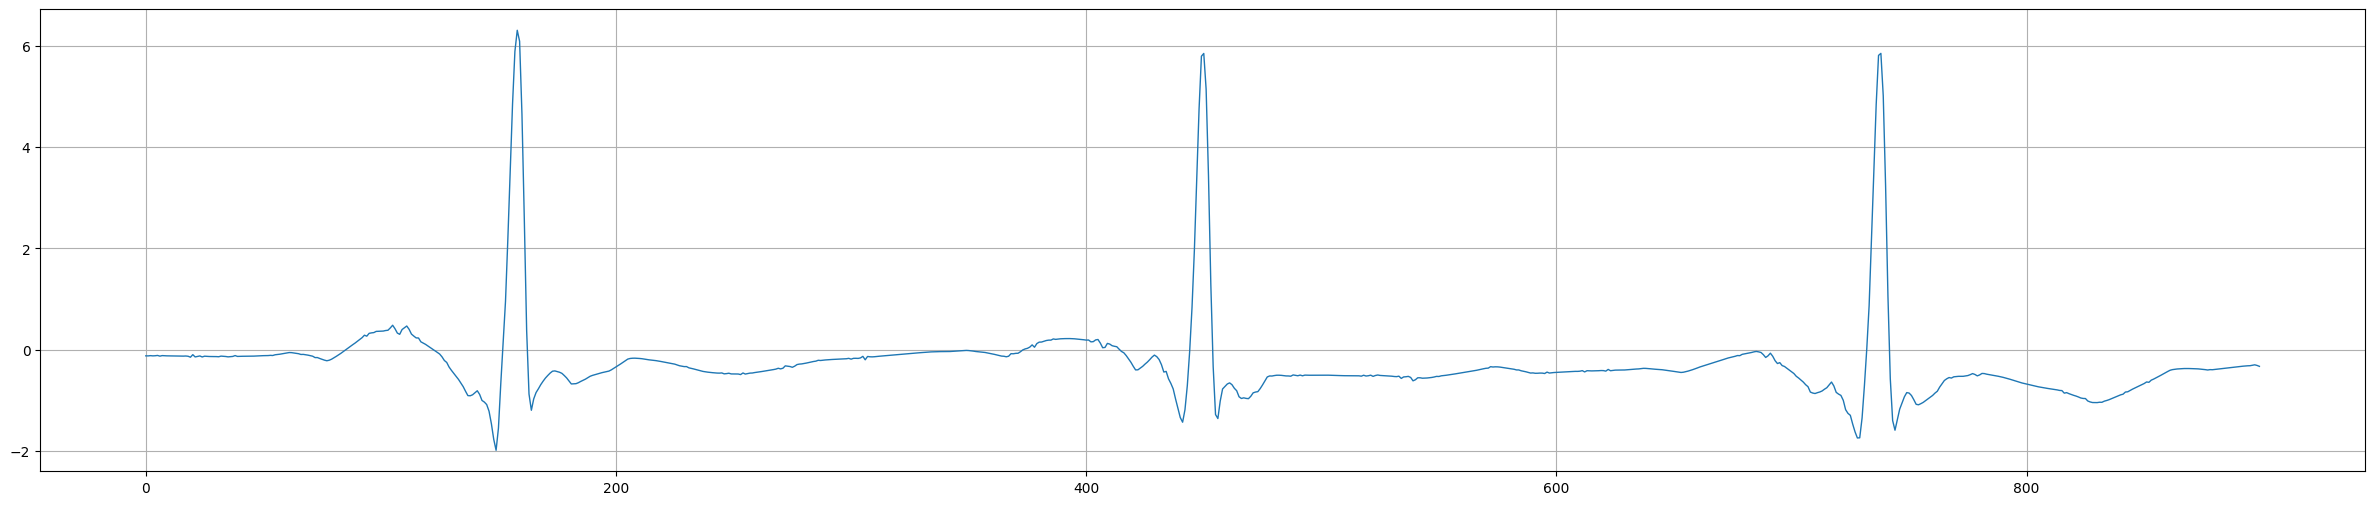

In [21]:
plt.plot(X[0])
plt.show()
X_train_df = pd.DataFrame(X)

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import antropy as ant

processed_data = []

for i, r in X_train_df.iterrows():
    r = list(r)
    
    # Time-domain features
    r_scaled = (r - np.min(r)) / (np.max(r) - np.min(r))  # Normalizing
    peaks, _ = find_peaks(r_scaled, height=0.3)
    rr_intervals = np.diff(peaks)
    
    if len(rr_intervals) > 0:
        mean_rr = np.mean(rr_intervals)
        min_rr = np.min(rr_intervals)
        max_rr = np.max(rr_intervals)
        median_hr = np.median(60 / rr_intervals)
    else:
        mean_rr = min_rr = max_rr = median_hr = np.nan
    
    # Entropy-based features
    sample_entropy = ant.sample_entropy(r)
    app_entropy = ant.app_entropy(r)
    perm_entropy = ant.perm_entropy(r, normalize=True)
    higuchi_fd = ant.higuchi_fd(r)
    # Combine all features
    features = [
        mean_rr, min_rr, max_rr, median_hr, sample_entropy, app_entropy, perm_entropy, higuchi_fd, y[i]
    ]
    
    processed_data.append(features)

# Create the final DataFrame
processedDF = pd.DataFrame(processed_data, columns=[
    'Mean_RR', 'Min_RR', 'Max_RR', 'Median_HR',
    'Sample_Entropy', 'App_Entropy', 'Perm_Entropy', 'Higuchi_FD', 'Label'
])

print(processedDF)



         Mean_RR  Min_RR  Max_RR  Median_HR  Sample_Entropy  App_Entropy  \
0     290.000000   288.0   292.0   0.206906        0.064243     0.120371   
1     283.500000   279.0   288.0   0.211694        0.051749     0.122942   
2      83.571429     3.0   241.0   1.276596        0.053266     0.099070   
3     288.000000   284.0   292.0   0.208374        0.064845     0.118910   
4     282.500000   279.0   286.0   0.212422        0.060348     0.108159   
...          ...     ...     ...        ...             ...          ...   
1978  240.000000   234.0   246.0   0.250156        0.061687     0.108099   
1979  244.000000   241.0   247.0   0.245939        0.055596     0.112673   
1980   42.500000     2.0   244.0   8.035714        0.063500     0.093130   
1981  235.000000   229.0   241.0   0.255486        0.084392     0.120659   
1982  246.000000   241.0   251.0   0.244003        0.067850     0.107668   

      Perm_Entropy  Higuchi_FD  Label  
0         0.737732    1.228166      0  
1      

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
processedDF = processedDF.dropna()
# Splitting features and labels
X = processedDF.drop(columns=['Label']).values
y = processedDF['Label'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to PyTorch tensors and move to the correct device
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)
y_tensor = (y_tensor != 0).long().to(device)  # Ensure it is on the correct device
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)  # First layer (fewer neurons)
        self.fc2 = nn.Linear(16, 16)          # Second layer
        self.fc3 = nn.Linear(16, 16) 
        self.fc4 = nn.Linear(16, num_classes) # Fourth layer (output)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)  # Dropout with 20% probability
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout after first layer
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)  # Dropout after second layer
        x = self.fc4(x)  # No activation, as CrossEntropyLoss expects raw scores (logits)
        return x
# Initialize the model
input_size = X.shape[1]  # Number of input features
num_classes = len(np.unique(y))  # Number of unique labels
model = NeuralNet(input_size, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/1000], Loss: 1.1484
Epoch [2/1000], Loss: 0.6096
Epoch [3/1000], Loss: 0.5377
Epoch [4/1000], Loss: 0.5206
Epoch [5/1000], Loss: 0.5018
Epoch [6/1000], Loss: 0.4963
Epoch [7/1000], Loss: 0.4867
Epoch [8/1000], Loss: 0.4816
Epoch [9/1000], Loss: 0.4784
Epoch [10/1000], Loss: 0.4667
Epoch [11/1000], Loss: 0.4711
Epoch [12/1000], Loss: 0.4586
Epoch [13/1000], Loss: 0.4529
Epoch [14/1000], Loss: 0.4575
Epoch [15/1000], Loss: 0.4525
Epoch [16/1000], Loss: 0.4477
Epoch [17/1000], Loss: 0.4430
Epoch [18/1000], Loss: 0.4425
Epoch [19/1000], Loss: 0.4412
Epoch [20/1000], Loss: 0.4468
Epoch [21/1000], Loss: 0.4542
Epoch [22/1000], Loss: 0.4426
Epoch [23/1000], Loss: 0.4169
Epoch [24/1000], Loss: 0.4307
Epoch [25/1000], Loss: 0.4294
Epoch [26/1000], Loss: 0.4396
Epoch [27/1000], Loss: 0.4303
Epoch [28/1000], Loss: 0.4305
Epoch [29/1000], Loss: 0.4279
Epoch [30/1000], Loss: 0.4121
Epoch [31/1000], Loss: 0.4254
Epoch [32/1000], Loss: 0.4117
Epoch [33/1000], Loss: 0.4218
Epoch [34/1000], Lo

In [28]:

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 83.63%
